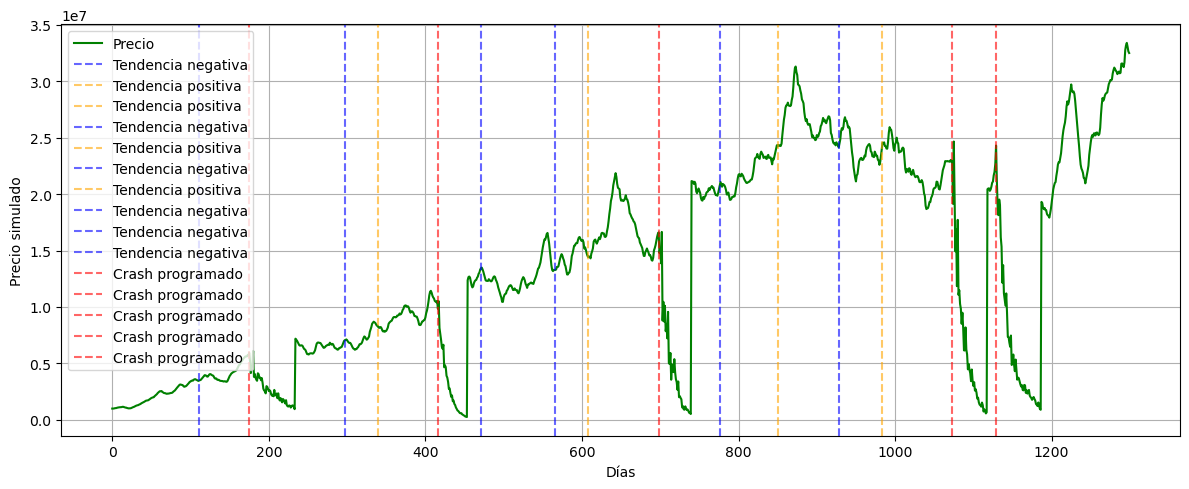

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#NO TOCAR
def simulate_multifractal_series(
    n_days=1300,
    base_price=1000,
    mu=0.0005,
    sigma=0.012,
    hurst=0.7,
    number_of_positive_trends=4,
    number_of_negative_trends=7,
    positive_trend_std_range=(1.5, 3.5),
    negative_trend_std_range=(1.5, 3.5),
    number_of_crashes=10,
    crash_std_range=(4, 10),
    crash_duration_range=(40, 100),
    crash_noise_std_range=(0.05, 0.3), 
    duration_positive_crash_trend=50,  
    duration_negative_crash_trend=50,  
    cap_to_minimum=True,
    minimum_price=0.01,
    return_avg_trend_lengths=True,
    seed=101
):
    np.random.seed(seed)

    # Crashes
    crash_points = []
    attempts = 0
    max_attempts = number_of_crashes * 50
    while len(crash_points) < number_of_crashes and attempts < max_attempts:
        duration = np.random.randint(*crash_duration_range)
        start = np.random.randint(100, n_days - duration - 100)
        end = start + duration
        overlap = any((start < ep and end > sp) for sp, ep in crash_points)
        if not overlap:
            crash_points.append((start, end))
        attempts += 1

    # Tendencias
    trend_points = []
    total_trends = number_of_positive_trends + number_of_negative_trends
    attempts = 0
    min_trend_duration = 5
    while len(trend_points) < total_trends and attempts < total_trends * 10:
        is_positive = len(trend_points) >= number_of_negative_trends
        avg_duration = duration_positive_crash_trend if is_positive else duration_negative_crash_trend
        duration = max(min_trend_duration, int(np.random.normal(loc=avg_duration, scale=10)))
        start = np.random.randint(100, n_days - duration - 100)
        end = start + duration
        overlap = any((start < ep and end > sp) for sp, ep in crash_points + trend_points)
        if not overlap:
            trend_points.append((start, end))
        attempts += 1

    trend_directions = [-1]*number_of_negative_trends + [1]*number_of_positive_trends
    np.random.shuffle(trend_directions)
    trend_intensities = [
        np.random.uniform(*negative_trend_std_range)*sigma if d == -1 else
        np.random.uniform(*positive_trend_std_range)*sigma
        for d in trend_directions
    ]

    # Retornos
    log_returns = np.zeros(n_days)
    for t in range(1, n_days):
        memory = hurst * log_returns[t - 1]
        innovation = sigma * np.random.normal()
        log_returns[t] = mu + memory + innovation
    price_series = base_price * np.exp(np.cumsum(log_returns))

    # Tendencias
    for (start, end), direction, intensity in zip(trend_points, trend_directions, trend_intensities):
        decay = np.linspace(1, 1 + direction * intensity, end - start)
        price_series[start:end] *= decay

    # Crashes 
    for start, end in crash_points:
        crash_intensity = np.random.uniform(*crash_std_range) * sigma
        noise_std = np.random.uniform(*crash_noise_std_range)
        crash_path = np.linspace(0, -crash_intensity, end - start) + np.random.normal(0, noise_std, end - start)
        crash_path = np.exp(crash_path)
        price_series[start:end] *= crash_path

    if cap_to_minimum:
        price_series = np.clip(price_series, minimum_price, None)

    avg_pos = np.mean([end - start for (start, end), d in zip(trend_points, trend_directions) if d == 1])
    avg_neg = np.mean([end - start for (start, end), d in zip(trend_points, trend_directions) if d == -1])

    if return_avg_trend_lengths:
        return price_series, trend_points, trend_directions, crash_points, avg_pos, avg_neg
    else:
        return price_series, trend_points, trend_directions, crash_points

# PARÁMETROS USABLES
series, trend_pts, trend_dirs, crash_pts, avg_pos, avg_neg = simulate_multifractal_series(
    n_days=1300,
    base_price=1000000,
    mu=0.0005,
    sigma=0.012,
    hurst=0.7,
    number_of_positive_trends=4,
    number_of_negative_trends=7,
    positive_trend_std_range=(1.5, 3),
    negative_trend_std_range=(1.5, 3),
    number_of_crashes=5,
    crash_std_range=(100, 400),
    crash_duration_range=(30, 60),
    crash_noise_std_range=(0.05, 0.2),
    duration_positive_crash_trend=45,  
    duration_negative_crash_trend=60, 
    cap_to_minimum=True,
    minimum_price=0.01,
    seed=101
)

# DETECTAR CRASHES
def detect_crashes(price_series, threshold_std=4):
    returns = np.diff(np.log(price_series))
    std_dev = np.std(returns)
    return np.where(returns < -threshold_std * std_dev)[0]

crash_detected = detect_crashes(series, threshold_std=4)

# VISUALIZACIÓN
plt.figure(figsize=(12, 5))
plt.plot(series, color='green', label='Precio')

used_positions = set()
def plot_line_once(x, color, label, style='--'):
    if x not in used_positions:
        plt.axvline(x=x, color=color, linestyle=style, alpha=0.6, label=label)
        used_positions.add(x)
    else:
        plt.axvline(x=x, color=color, linestyle=style, alpha=0.3)

for (start, _), direction in zip(trend_pts, trend_dirs):
    c = 'orange' if direction == 1 else 'blue'
    label = 'Tendencia positiva' if direction == 1 else 'Tendencia negativa'
    plot_line_once(start, color=c, label=label)

for start, _ in crash_pts:
    plot_line_once(start, color='red', label='Crash programado')

for t in crash_detected:
    plot_line_once(t, color='black', label='Crash detectado', style=':')

plt.xlabel('Días')
plt.ylabel('Precio simulado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()